# CEB 35300, Phylogenetic Comparative Methods 
## University of Chicago, 2021<br>Andrew Hipp, ahipp@mortonarb.org
### Week 7: Ornstein-Uhlenbeck models - components

This week, we are going to focus on how O-U models work. We won't create a full-blown implementation that you would analyze data with, because there are already many good ones (see the last section of this tutorial for pointers to packages you may use to analyze your data). 

Instead, we'll focus on understanding how the elements of the O-U model implementations work, so they don't seem like magic (they aren't, though they are pretty cool!). You already know how generalized least squares works, and the standard O-U model implementation uses the same machinery.

Here, we'll implement the basics of the OU model following Hansen 1997 and Butler and King 2004 (appendix).

#### Get an example tree
Let's first make a small tree we can play with. We'll build a tree that has a simple structure that allows us to see what it looks like for species to have evolved in one, two, or three regimes. Note that this tree is _far too small_ for an actual analysis of trait evolution under any reasonable O-U model, let alone a three-regime O-U model, which would have:
* one Brownian motion rate parameter, $\sigma$
* one rate of adaptation parameter, $\alpha$
* three optimum parameters, $\theta_i$ (where $i = {1,2,3}$)

for a total of $K = 5$ parameters on a tree with 6 tips. _Too many parameters for our dataset_ (a rule of thumb for regression-based methods is 10-20 data points per free parameter). But a larger tree would be too difficult to read.

So let's make a tree with five tips, and a total tree depth of 1.0:

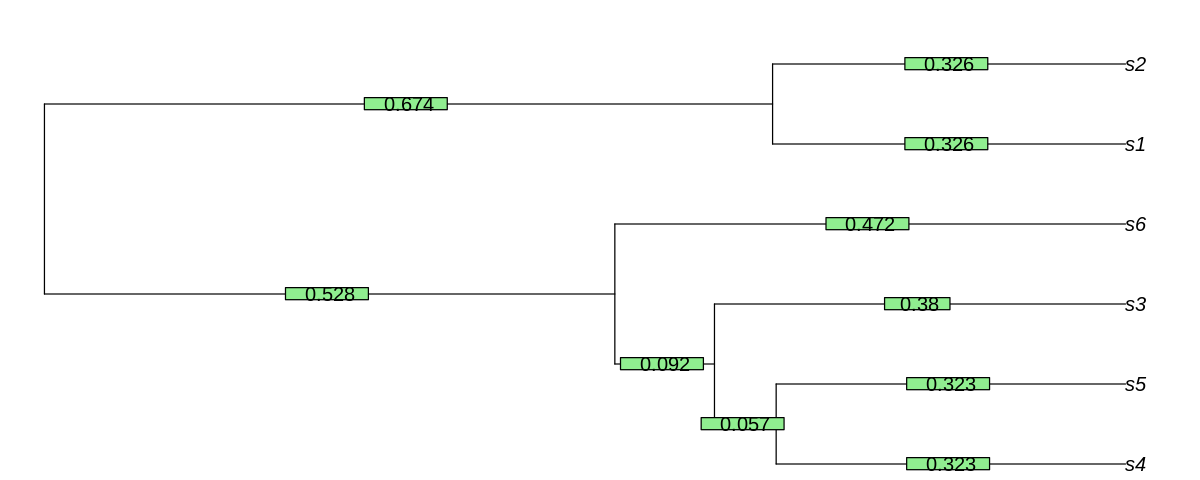

In [1]:
library(ape)
options(repr.plot.width=10, repr.plot.height=4)
par(mar = c(0,0,2,0))
tr <- list(edge = matrix(c(7L, 9L,
                          9L, 10L,
                          10L, 11L,
                          11L, 4L,
                          11L, 5L,
                          10L, 3L, 
                          9L, 6L,
                          7L, 8L,
                          8L, 1L,
                          8L, 2L), ncol = 2, byrow = T, dimnames = list(NULL, c('anc', 'desc'))), 
          edge.length = c(0.527646570653822, 0.0921654720483081, 
                          0.0570646922113782, 0.323123264983397, 
                          0.323123264983397, 0.380187957176582, 
                          0.472353429285534, 0.673568669210027, 
                          0.326431330789973, 0.326431330789973), 
          Nnode = 5L, 
          tip.label = c("s1", "s2", "s3", "s4", "s5", "s6")
          )
class(tr) <- 'phylo'
plot(tr)
edgelabels(text = round(tr$edge.length, 3))

# Covariance matrix under the O-U model
We know the covariance matrix (C) well. Let's look at C for this tree.

In [2]:
C = round(vcv(tr), 3) # rounding just so it is easier to read
C

,s1,s2,s3,s4,s5,s6
s1,1.000,0.674,0.000,0.000,0.000,0.000
s2,0.674,1.000,0.000,0.000,0.000,0.000
s3,0.000,0.000,1.000,0.620,0.620,0.528
s4,0.000,0.000,0.620,1.000,0.677,0.528
s5,0.000,0.000,0.620,0.677,1.000,0.528
s6,0.000,0.000,0.528,0.528,0.528,1.000


... and $V = \sigma^2 C$. 

From Hansen (1997, 2014) as well as Butler and King (2004, appendix, formula A5) you know what the elements of V are under an O-U model:

$$V_{ij} = \Big( {\sigma^2 \over 2 \alpha} \Big) e^{-2 \alpha (T-s_{ij})} (1 - e^{-2 \alpha s_{ij}}) $$


$$\tilde{V}_{ij} = {e^{-2 \alpha (T-s_{ij})} (1 - e^{-2 \alpha s_{ij}}) \over 2 \alpha} $$

where:
* $\alpha$ is the rate of adaptation
* $\sigma^2$ is the Brownian motion rate parameter
* $T$ is the tree depth
* $s_{ij}$ is the covariance between taxa $i$ and $j$, i.e., the distance from the MRCA of two tips to the root of the tree.

As $\alpha \to 0$, $V_{OU}$ should converge on $V_{Brownian motion}$, where each element $V_{ij} = \sigma^2 s_{ij}$. Let's see if it does:

In [3]:
V <- function(tr, alpha = 1, rescale = T) {
     Tm = max(node.depth.edgelength(tr))
     C = vcv(tr)
     out = (1 / 2*alpha) * exp(-2 * alpha * (Tm-C)) * (1 - exp(-2 * alpha * C))
     if(rescale) out <- out / max(out)
     return(out)
     }

myV <- V(tr, alpha = 0.3)
round(myV, 3)

,s1,s2,s3,s4,s5,s6
s1,1.000,0.606,0.000,0.000,0.000,0.000
s2,0.606,1.000,0.000,0.000,0.000,0.000
s3,0.000,0.000,1.000,0.548,0.548,0.453
s4,0.000,0.000,0.548,1.000,0.609,0.453
s5,0.000,0.000,0.548,0.609,1.000,0.453
s6,0.000,0.000,0.453,0.453,0.453,1.000


and it does! Note that at $\alpha = 0$, $V_{OU}$ becomes undefined, so we just useda low value of $\alpha$ here.

On your own, take a moment and run this function with various levels of $\alpha$ to see what the covariance structure looks like. If you are feeling adventurous (and I hope you are!), compare $\alpha$ transformations to $\lambda$ transformations for the same tree. (You can see what lambda transformations using

```
newV <- vcv(tr) * lambda
diag(newV) <- diag(vcv(tr))
```

# The weight matrix: downweighting the past
The second new element of the O-U model is a weight matrix. "What is this weight matrix," you may ask, "and why do we want it?" Think about the evolutionary path describing the history that a species has passed through from the root of the tree to the common day. Imagine a phylogeny that has three adaptive regimes (high, medium and low rainfall, for example; or three host organisms if you are looking at a bacterium or endophytic fungus):

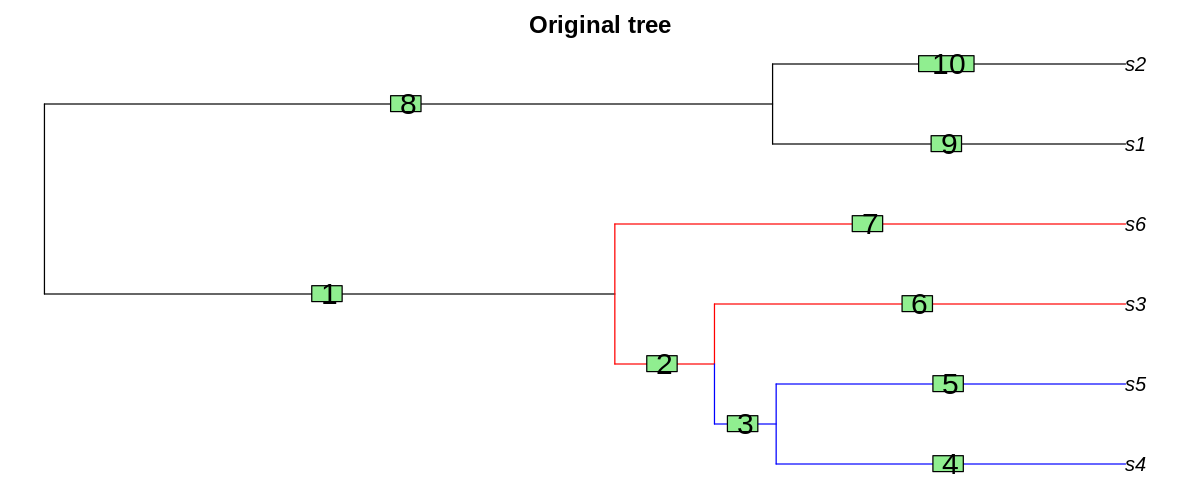

In [4]:
library(geiger)
b = 'black'; r = 'red'; x = 'blue'
regimes = c(b, r, x, x, x, r, r, b, b, b)
par(mar = c(0,0,2,0))
plot(tr, edge.color = regimes, main = 'Original tree')
edgelabels(cex = 1.5)

You can see that taxa s1 and s2 evolved only in one regime, while taxa s3 and s6 evolved in 2 and s4 and s5 evolved in three different selective regimes. Intuitively, you would expect a taxon's current selective regime to have more effect on that taxon's phenotype. If there is any phylogenetic signal, however, even past selective regimes have an effect on the distribution of observed phenotypes.

The discounting of the past, or the pull of the present, is even more dramatic when natural selection is strong. Take a look at a tree rescaled to an OU $\alpha = 3$, equivalent to $t_{1/2} = ln(2) / \alpha = 0.231$, and compare to a $\lambda$ rescale of 0.1:

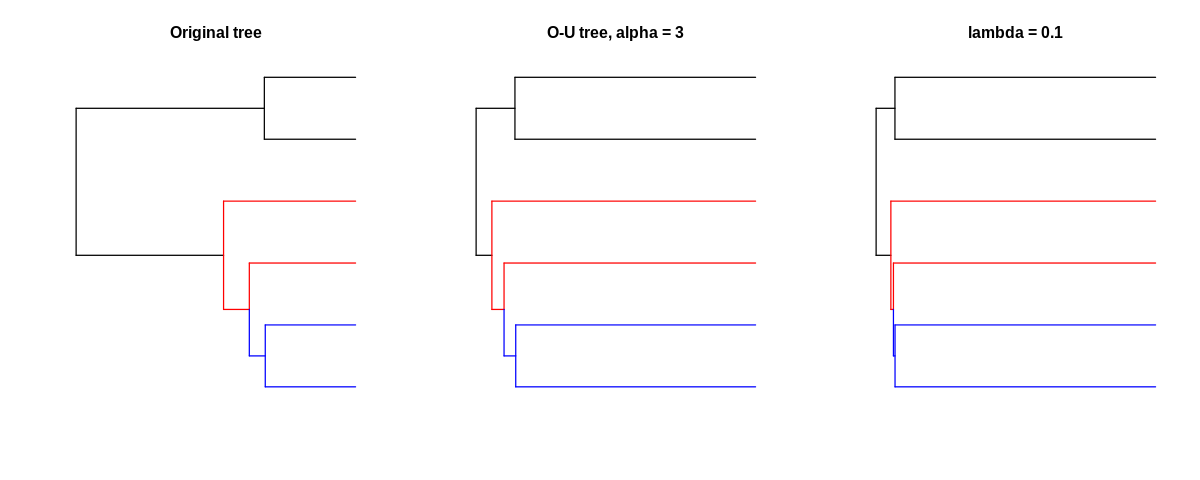

In [5]:
layout(matrix(1:3, 1))
plot(tr, edge.color = regimes, show.tip.label = F, main = 'Original tree')
plot(rescale(tr, 'OU', 3), edge.color = regimes, show.tip.label = F, main = 'O-U tree, alpha = 3')
plot(rescale(tr, 'lambda', 0.1), edge.color = regimes, show.tip.label = F, main = 'lambda = 0.1')

We use the weight matrix $W_{ik}$ to weight each of $k$ regimes for each taxon $i$ by the amount of time each taxon has spent in each regime, discounting the past appropriately. $W_{ik}$ is a matrix with $k$ columns (corresponding to the number of regimes) and $i$ rows (corresponding to the number of species). Thus, for our tree, $W_{ik}$ will be a 6 x 3 matrix. 

Let's see how we calculate the weight matrix. For each branch, we calculate its individual weight as:

$$e^{\alpha t_i^\gamma} - e^{\alpha t_i^{\gamma-1}}$$

where $t_i^\gamma$ is the ending time of the branch and $t_i^{\gamma-1}$ is the starting time.... time in this formulation proceeds from $t = 0$ at the root of the tree to $t = T$ at the tips. So let's get all those individual branch weights:

[1] "example weights"


edgeNumb,edge.t,edge.l,w_0.1,w_1.0,w_5.0
1,0.000,0.528,0.054,0.695,12.988
2,0.528,0.092,0.010,0.164,8.189
3,0.620,0.057,0.006,0.109,7.323
4,0.677,0.323,0.035,0.751,118.913
5,0.677,0.323,0.035,0.751,118.913
6,0.620,0.380,0.041,0.860,126.236
7,0.528,0.472,0.051,1.023,134.425
8,0.000,0.674,0.070,0.961,28.016
9,0.674,0.326,0.035,0.757,119.397
10,0.674,0.326,0.035,0.757,119.397


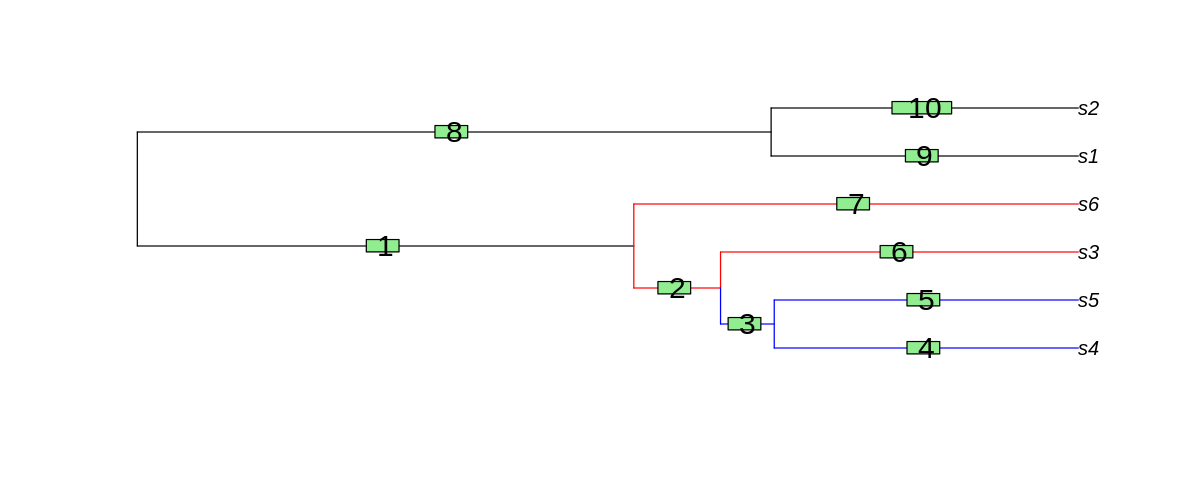

In [11]:
w.branch = function(tr, alpha = 0.1) {
    t_i.mat <- apply(tr$edge, 1:2, function(x) node.depth.edgelength(tr)[x])
    exp(alpha * t_i.mat[, 2]) - exp(alpha * t_i.mat[, 1]) 
}

print('example weights')
round(cbind(edgeNumb = seq(dim(tr$edge)[1]),
            edge.t = node.depth.edgelength(tr)[tr$edge[, 1]],
            edge.l = tr$edge.length,
            w_0.1= w.branch(tr),
            w_1.0 = w.branch(tr, alpha = 1),
            w_5.0 = w.branch(tr, alpha = 5)),
      3)
plot(tr, edge.color = regimes)
edgelabels(cex = 1.5)

You can see that the weight of each branch&mdash;the effect that it has on the tip states&mdash;is influenced by both the length and age of the branch: the longer a branch is or the more recent it is, the higher it's weight. Try different values of alpha in the `w.branch` function to see how it works.

Now, we need to know which branches each tip passes through. We can get the nodes using the `Ancestors` function in [phangorn](https://cran.r-project.org/web/packages/phangorn/index.html), then turn these nodes into branches by looking up the edges:

In [7]:
library(phangorn)
node.list <- lapply(1:length(tr$tip.label), function(i) c(i, Ancestors(tr, i)))
edge.list <- lapply(node.list, function(x) which(tr$edge[, 2] %in% x))
names(edge.list) <- tr$tip.label
print(edge.list)

$s1
[1] 8 9

$s2
[1]  8 10

$s3
[1] 1 2 6

$s4
[1] 1 2 3 4

$s5
[1] 1 2 3 5

$s6
[1] 1 7



As an exercise, look at the test tree and use `edgelabels()` to convince yourself that we've got it right.

Now, we already have a vector that tells us which branch is in which regime:

In [8]:
cbind(branch = seq(dim(tr$edge)[1]), regime = regimes)

branch,regime
1,black
2,red
3,blue
4,blue
5,blue
6,red
7,red
8,black
9,black
10,black


Combining this with the list above using `intersect`, we can say for each species $i$ what its weighting should be for each regime $k$. We'll use a nested loop to make very clear how this works, using $\alpha$ = 1

In [9]:
W <- function(tr, regimes, alpha = 1, includeRoot = F) {
    Tm = max(node.depth.edgelength(tr))
    out <- matrix(NA, 
                  nrow = length(tr$tip.label), 
                  ncol = length(unique(regimes)),
                  dimnames = list(sort(tr$tip.label), sort(unique(regimes)))
                  )
    w.temp <- w.branch(tr, alpha)
    for(i in tr$tip.label) {
    for(k in unique(regimes)) {
        out[i, as.character(k)] <- exp(-alpha * Tm) * sum(w.temp[intersect(edge.list[[i]], which(regimes == k))])
    }
  }
  if(includeRoot) out <- cbind('0' = exp(-alpha * Tm), out) 
  out
}
myW <- W(tr, regimes, alpha = 0.65, includeRoot= F)
myW

,black,blue,red
s1,0.4779542,0.0000000,0.00000000
s2,0.4779542,0.0000000,0.00000000
s3,0.2135830,0.0000000,0.26437127
s4,0.2135830,0.2189547,0.04541653
s5,0.2135830,0.2189547,0.04541653
s6,0.2135830,0.0000000,0.26437127


As you can see, s4 and s5 each have some weight in all three regimes, and the regime closest to the present has greatest weight... but even ancestral regimes have some weight under this relatively low $\alpha$, and $C$ will also come to bear on the outcome.

The root has come to be considered a nuisance parameter in most OU model implementations; this wasn't always the case, but it's just very hard to estimate and mostly meaningless at values of $\alpha$ that are very high. To see the weight of the root, set `includeRoot = TRUE`. You'll see that as $\alpha$ increases, the weight of the root state drops rapidly, making it hard to estimate; this is exactly what we expect for high rates of adaptation. Strong natural selection effaces phylogenetic history.

As an experiment, change alpha in the above call to `W` and see how the effect each selective regime changes for all taxa. At what level of alpha is the effect of the root of the tree (column 0) effectively effaced?

## Estimation time!
Now we have all the pieces in place. It turns out, as we discussed, that the GLS estimator for the OU model is a weighted regression, where the regression parameters estimate $\theta$, the vector of optima. We'll implement the GLS $\theta$ and variance estimators here; note that if you are following along in Hansen 1997, this will match closely; if you are following the appendix of Butler and King 2004, there is a slight error in the $\theta$ estimator (see if you can find it...)

In [10]:
theta <- function(tr, regimes, alpha, x, ...) {
    w <- W(tr, regimes, alpha, ...)
    v <- V(tr, alpha)
    out <- solve(t(w) %*% solve(v) %*% w) %*% t(w) %*% solve(v) %*% as.matrix(x)
    out
}

sigma2 <- function(tr, regimes, alpha, ...) {
    w <- W(tr, regimes, alpha, ...)
    v <- V(tr, alpha)
    out <- solve(t(w) %*% solve(v) %*% w)
    out <- structure(diag(out), names = row.names(out))
    out
}
theta(tr, regimes, alpha = 100, x = c(1, 2, 200, 10, 11, 201), includeRoot = F)


black,1.5
blue,10.5
red,200.5


Note that at very high levels of $\alpha$, the estimated regimes just match up with the tip states. That's not surprising... but w/ indadequately informative data, low rates of adaptation are hard to fit: the model becomes quite unstable. Take a look at Hansen 1997, Table 2, and his discussion of low values of $\alpha$ on the bottom of pg 1348, left column. Try substituting in lower levels of alpha and see what results you get. Try changing the tip states, remembering that x is numbered in the same order as the tip label numbering (s1 through s6), not following the topology from top to bottom.

# Implementations
Now that you understand how the O-U model is built, you are probably just _dying_ to try it out with your data, or with the sample data provided with this class. There are many O-U implementations. If you want an entry point, you might try these:

* [ouch](https://cran.r-project.org/web/packages/ouch/) is the implementation that really made O-U models practical. Focuses on discrete models with a single $\alpha$ and single $\sigma$, but multiple selective regimes.
* [OUwie](https://cran.r-project.org/web/packages/OUwie/) extends the parameter space presented in `ouch`, allowing multiple $\alpha$ and $\sigma$.
* [mvSLOUCH](https://cran.r-project.org/web/packages/mvSLOUCH/index.html) implements the stochastic linear O-U model of Hansen et al. 2008 and the multiple responses extension of Bartoszek et al. 2012. I have used the old SLOUCH quite a bit, but it was implemented as a set of scripts, not a true package, and was not straightforward to use. I have not used `mvSLOUCH`, but this is where I would start if I were going to use Hansen's 2008 approach.
* [l1ou](https://github.com/khabbazian/l1ou) uses a sophisticated search approach, a novel information criterion tailored to model-selection in a phylogenetic framework, and iterative searching to investigate convergence. This approach also allows for multiple traits to be evolving according to a single suite of selective regimes, but as it does not take into account correlation structure among these, it is not fully multivarite. `l1ou` is not on CRAN. To install, use: 
```
install.packages("devtools")
install_github("khabbazian/l1ou")
```
I used this method in our [2018 oak convergence paper](https://github.com/andrew-hipp/oak-convergence-2017), for which all code is provided in this link. 
* [PhylogeneticEM](https://cran.r-project.org/web/packages/PhylogeneticEM/index.html) builds on `l1ou`, taking into account correlation structure among traits. The method is rather new ([Bastide et al. 2018](https://academic.oup.com/sysbio/advance-article/doi/10.1093/sysbio/syy005/4827615)), and I have not yet taken the package for a drive.
* [bayou](https://cran.r-project.org/web/packages/bayou/) uses rjMCMC to traverse among O-U models, investigating where changes in selective regime have occurred. One can also evaluate the likelihood of any particular O-U configuration.
* [phylolm](https://cran.r-project.org/web/packages/phylolm/index.html) provides functions for fitting phylogenetic linear models and generalized linear models, including O-U models. I have used this package for all three approaches and found it easy to use.

As popular as Ornstein-Uhlenbeck models have become, I'm sure there are other implementations out there. I have not included non-R implementations here (e.g., Emilia Martins' [COMPARE](http://www.indiana.edu/~martinsl/compare/), which was perhaps the first O-U implementation available... and now that I've said I have not included it I guess that I actually have), nor implementations that just estimate the O-U scaling parameter without also fitting multiple selective regimes.